<a href="https://colab.research.google.com/github/menduv/mtg-Jamendo/blob/main/CNN_mtg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN model for classification of audio files with genre tags

In [1]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing the spectrogram images stored in a zip file
import zipfile
with zipfile.ZipFile("C:/Users/mendu/Desktop/Deep-Learning-Projects/data/cropped_archive_22.zip","r") as zip_ref:
    zip_ref.extractall("/content/sample_mel")

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers

In [3]:
#checking the no. of spectrograms and their size
mel_dir = 'C:/Users/mendu/Desktop/Deep-Learning-Projects/data/cropped_mel'
mel_list = os.listdir(mel_dir)
mel_npy = np.load(f'{mel_dir}/{mel_list[25]}')
print('Count of npy files: ', len(mel_list))
print('Size of image: ', mel_npy.shape)

Count of npy files:  4480
Size of image:  (96, 1406)


## Loading the mtg dataframe and filtering it to include top 5 genres from the sample

In [4]:
#importing csv that contains the metafile of all the tracks
df_all = pd.read_csv('C:/Users/mendu/Desktop/Deep-Learning-Projects/data/mtg_cleaned.csv', index_col = [0])

In [5]:
df_all.head()

,track_id,artist_id,album_id,path,duration,genre,instrument,mood
1,214,14,31,14/214.mp3,124.6,punkrock,NaN,NaN
2,215,14,31,15/215.mp3,151.4,metal,NaN,NaN
3,216,14,31,16/216.mp3,234.9,metal,NaN,NaN
4,217,14,31,17/217.mp3,127.9,punkrock,NaN,NaN
5,218,14,31,18/218.mp3,180.7,punkrock,NaN,NaN


In [6]:
#list of all the track_ids in the sample zip file
track_ids = [int(file_name.replace('.npy', '')) for file_name in mel_list]

#filtering only those tracks to the dataset
df = df_all[df_all['track_id'].isin(track_ids)]

#only taking the first genre from the genre column
df['genre'] = df['genre'].str.split(',').str[0]

#only keeping the tracks and genre column
df = df[['track_id', 'genre']]

In [7]:
#calculating the most frequent genres in the sample and only keeping the top five in the df
genre_count = pd.DataFrame(df.genre.value_counts().rename_axis('genre').reset_index(name='counts'))

#list of top five genres
top_genres = list(genre_count.genre[:10])

#filtering df to only keep
df = df[df['genre'].isin(top_genres)].sort_values(by = 'track_id', ascending = True).reset_index(drop = True)

df

,track_id,genre
0,6606,dance
1,6607,dance
2,6608,dance
3,6609,dance
4,6610,dance
...,...,...
3096,1420700,chillout
3097,1420704,dance
3098,1420705,dance
3099,1420706,dance


In [8]:
#List of all the track_ids that are in the sample and have top5
train_track_ids = list(df['track_id'].values)

In [9]:
train_track_ids[:5]

[6606, 6607, 6608, 6609, 6610]

### Cropping mel-spectrograms to the size (96, 1406)

In [ ]:
!mkdir '/content/cropped_mel'

In [ ]:
def crop_melspectrogram(mel_spectrogram, target_frames, hop_size):
    # Crop or pad the mel spectrogram to the target number of frames
    if mel_spectrogram.shape[1] >= target_frames:
        cropped_mel_spectrogram = mel_spectrogram[:, :target_frames]
    else:
        # Pad with zeros if the original length is less than the target
        padding = np.zeros((mel_spectrogram.shape[0], target_frames - mel_spectrogram.shape[1]))
        cropped_mel_spectrogram = np.hstack((mel_spectrogram, padding))

    return cropped_mel_spectrogram


In [ ]:
folder_path = '/content/sample_mel'
cropped_folder_path = '/content/cropped_mel'

# Assuming the hop size used during mel spectrogram calculation
hop_size = 256
sample_rate = 12000

# Calculate the target number of frames based on the desired duration (e.g., 30 seconds)
desired_duration_seconds = 30
target_frames = int(desired_duration_seconds * (1 / (hop_size / sample_rate)))

# Iterate over files in the folder
for filename in train_track_ids:
    file_path = os.path.join(folder_path, str(filename) +'.npy')

    mel_spectrogram = np.load(file_path)

    cropped_mel_spectrogram = crop_melspectrogram(mel_spectrogram, target_frames, hop_size)

    np.save(os.path.join(cropped_folder_path, str(filename)), cropped_mel_spectrogram)

In [ ]:
print('The number of cropped mel-spectrogram in the cropped_mel folder is:',len(os.listdir('/content/cropped_mel')))

The number of cropped mel-spectrogram in the cropped_mel folder is: 1016


In [ ]:
'''To display cropped and original mels'''

# crop_mel_307 = np.load('/content/cropped_mel/1001307.npy')
# mel_307 = np.load('/content/sample_mel/1001307.npy')

# plt.imshow(crop_mel_307, aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('Mel Frequency Bin')
# plt.title('Mel-Spectrogram')
# plt.colorbar()
# plt.show()

# plt.imshow(mel_307, aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('Mel Frequency Bin')
# plt.title('Mel-Spectrogram')
# plt.colorbar()
# plt.show()

# Training the model

In [11]:
#loading the cropped .npy files

folder_path_mel = 'C:/Users/mendu/Desktop/Deep-Learning-Projects/data/cropped_mel'
filenames = os.listdir(folder_path_mel)

data = []
i = 0

for filename in train_track_ids:
  filename_npy = str(filename) + '.npy'
  file_path = os.path.join(folder_path_mel, filename_npy)
  data.append(np.load(file_path))
  if i < 10 :
    print(filename)
  i = i+1

data = np.array(data)


6606
6607
6608
6609
6610
6611
6719
6720
6721
6722


In [11]:
#normalize data
data = data.astype('float32')/255.0

In [12]:
data.shape

(3101, 96, 1406)

In [13]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 96, 1406, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['genre']), test_size=0.2, random_state=42)

In [14]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

In [15]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]

In [16]:
num_classes

10

In [17]:
# Convert images to RGB using TensorFlow operations
def grayscale_to_rgb(images):
    return tf.image.grayscale_to_rgb(tf.convert_to_tensor(images))

# Assuming you've already converted your grayscale images to 3 channels with grayscale_to_rgb
X_train_rgb = grayscale_to_rgb(X_train)  # This should output images with shape [height, width, 3]
X_val_rgb = grayscale_to_rgb(X_val)      # Same as above

# Initialize the EfficientNetB0 model (pre-trained on ImageNet)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 1406, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Build the new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])




16705208/16705208 [==============================] - 5s 0us/step


In [18]:
# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose= 1)

Epoch 1/10


78/78 [==============================] - 199s 2s/step - loss: 11.2609 - accuracy: 0.2359 - val_loss: 2.8998 - val_accuracy: 0.2882
Epoch 2/10
78/78 [==============================] - 172s 2s/step - loss: 2.7578 - accuracy: 0.2839 - val_loss: 2.2584 - val_accuracy: 0.2158
Epoch 3/10
78/78 [==============================] - 159s 2s/step - loss: 2.0557 - accuracy: 0.2891 - val_loss: 2.0317 - val_accuracy: 0.2947
Epoch 4/10
78/78 [==============================] - 163s 2s/step - loss: 1.8923 - accuracy: 0.3508 - val_loss: 1.9717 - val_accuracy: 0.3382
Epoch 5/10
78/78 [==============================] - 162s 2s/step - loss: 1.8393 - accuracy: 0.3710 - val_loss: 1.9572 - val_accuracy: 0.3205
Epoch 6/10
78/78 [==============================] - 179s 2s/step - loss: 1.8160 - accuracy: 0.3931 - val_loss: 1.9093 - val_accuracy: 0.3736
Epoch 7/10
78/78 [==============================] - 162s 2s/step - loss: 1.8843 - accuracy: 0.3677 - val_loss: 1.8907 - val_accuracy: 0.3543
Epoch 8/10

In [19]:
# Train for 10 more epochs
history_20 = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), initial_epoch=10, verbose= 1)

Epoch 11/20
78/78 [==============================] - 188s 2s/step - loss: 1.7928 - accuracy: 0.3786 - val_loss: 1.9900 - val_accuracy: 0.3301
Epoch 12/20
78/78 [==============================] - 151s 2s/step - loss: 1.7358 - accuracy: 0.4109 - val_loss: 1.9343 - val_accuracy: 0.3414
Epoch 13/20
78/78 [==============================] - 157s 2s/step - loss: 1.6708 - accuracy: 0.4250 - val_loss: 1.8883 - val_accuracy: 0.3285
Epoch 14/20
78/78 [==============================] - 160s 2s/step - loss: 1.6830 - accuracy: 0.4185 - val_loss: 1.9456 - val_accuracy: 0.3591
Epoch 15/20
78/78 [==============================] - 161s 2s/step - loss: 1.7205 - accuracy: 0.4004 - val_loss: 1.8793 - val_accuracy: 0.3494
Epoch 16/20
78/78 [==============================] - 157s 2s/step - loss: 1.6049 - accuracy: 0.4270 - val_loss: 1.8558 - val_accuracy: 0.3317
Epoch 17/20
78/78 [==============================] - 159s 2s/step - loss: 1.6237 - accuracy: 0.4375 - val_loss: 1.9196 - val_accuracy: 0.3607
Epoch 

In [20]:
# Train for 10 more epochs
history_30 = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), initial_epoch=20, verbose= 1)

Epoch 21/30
78/78 [==============================] - 155s 2s/step - loss: 1.5453 - accuracy: 0.4560 - val_loss: 1.8739 - val_accuracy: 0.3671
Epoch 22/30
78/78 [==============================] - 164s 2s/step - loss: 1.6203 - accuracy: 0.4355 - val_loss: 1.9015 - val_accuracy: 0.3414
Epoch 23/30
78/78 [==============================] - 154s 2s/step - loss: 1.6120 - accuracy: 0.4427 - val_loss: 2.0264 - val_accuracy: 0.3253
Epoch 24/30
78/78 [==============================] - 154s 2s/step - loss: 1.5970 - accuracy: 0.4415 - val_loss: 1.8902 - val_accuracy: 0.3269
Epoch 25/30
78/78 [==============================] - 155s 2s/step - loss: 1.5515 - accuracy: 0.4536 - val_loss: 1.9149 - val_accuracy: 0.3269
Epoch 26/30
78/78 [==============================] - 160s 2s/step - loss: 1.5852 - accuracy: 0.4435 - val_loss: 1.9055 - val_accuracy: 0.3510
Epoch 27/30
78/78 [==============================] - 153s 2s/step - loss: 1.5448 - accuracy: 0.4613 - val_loss: 2.0061 - val_accuracy: 0.3092
Epoch 

In [22]:
# Save the model
model.save('C:/Users/mendu/Desktop/Deep-Learning-Projects/data/efficientnet_3k_30ep.keras')

In [23]:
# Load the model
loaded_model = load_model('C:/Users/mendu/Desktop/Deep-Learning-Projects/data/efficientnet_3k_30ep.keras')

In [24]:
# last val loss and val acc
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

20/20 [==============================] - 35s 2s/step - loss: 2.2586 - accuracy: 0.3253
Validation Loss: 2.25856614112854, Validation Accuracy: 0.3252817988395691


In [25]:
# Concatenate the old and new history
full_history = {}
for key in history.history.keys():
    full_history[key] = history.history[key] + history_20.history[key] + history_30.history[key]

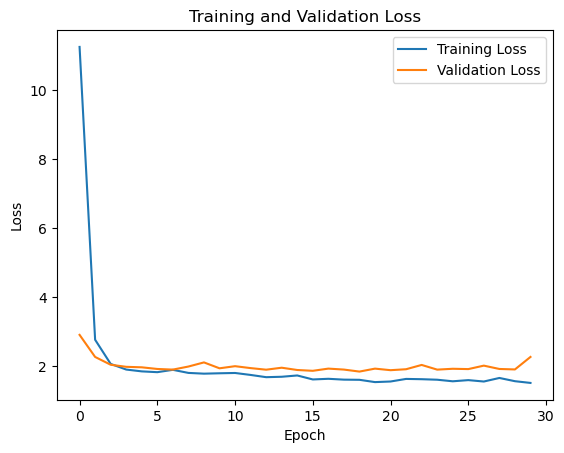

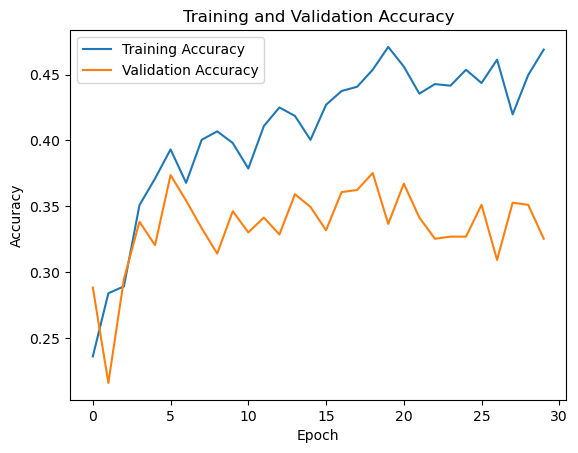

In [26]:
# Plot training loss
plt.plot(full_history['loss'], label='Training Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(full_history['accuracy'], label='Training Accuracy')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
'''import matplotlib.pyplot as plt

# Define the data
epochs = list(range(1, 31))  # Assuming 30 epochs
train_loss = [3.1024, 2.3673, 2.2814, 2.2056, 2.1723, 2.1417, 2.1223, 2.1314, 2.1052, 2.1025, 2.0961, 2.0911, 2.0806, 2.1007, 2.0791, 2.0792, 2.0732, 2.0681, 2.0666, 2.0602, 2.0665, 2.0690, 2.0689, 2.0640, 2.0514, 2.0593, 2.0629, 2.0557, 2.0695, 2.0646]
val_loss = [2.3848, 2.2317, 2.1796, 2.1162, 2.0936, 2.0726, 2.0700, 2.0816, 2.1067, 2.0504, 2.0372, 2.0261, 2.0269, 2.0264, 2.0271, 2.0361, 2.0115, 2.0132, 1.9988, 2.0171, 2.0062, 2.0093, 2.0190, 2.0003, 1.9912, 2.0077, 2.0126, 1.9861, 2.0034, 2.0032]
train_accuracy = [0.2343, 0.2407, 0.2444, 0.2415, 0.2464, 0.2577, 0.2556, 0.2569, 0.2593, 0.2782, 0.2621, 0.2754, 0.2625, 0.2681, 0.2839, 0.2762, 0.2730, 0.2815, 0.2806, 0.2786, 0.2774, 0.2750, 0.2810, 0.2742, 0.2843, 0.2738, 0.2742, 0.2766, 0.2815, 0.2802]
val_accuracy = [0.2560, 0.2609, 0.2754, 0.2593, 0.2625, 0.2609, 0.2705, 0.2802, 0.2609, 0.2271, 0.2866, 0.2754, 0.2882, 0.2818, 0.2915, 0.2866, 0.2915, 0.2995, 0.3043, 0.3060, 0.2947, 0.2995, 0.2866, 0.3027, 0.3124, 0.3043, 0.3060, 0.3140, 0.2963, 0.2995]

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
'''

In [ ]:
#This was without l2 reg

'''
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 1406, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional layers to fully connected layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Introducing dropout for regularization

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for an overview of the architecture
model.summary()'''

In [ ]:
'''
import keras
# Save the entire model to a file
model.save('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')

# Load the model back
loaded_model = keras.models.load_model('/content/drive/MyDrive/colab_data/simple_cnn_3kmel.keras')'''

In [ ]:
'''
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
'''